Imports:

In [3]:
%matplotlib inline 
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import mpld3

In [4]:
mpld3.enable_notebook()

Construct differential equations to be solved by ODE solver:

Note: the model has 7 disease and 9 age compartments, therefore is a described by a set of 63 equations. The differential equation definition splits the 63 elements of the time series observations into 7 compartments and constructs the evolution across age groups in a vectorized way. 

> Arguments:
1. `Z` - value of time series levels (a 63 element vector)
2. `t` - time periods of model (scalar)
3. `N` - total population (scalar) 
4. `beta` - infection rate (scalar)
5. `X` - contact probability matrix (9x9 matrix - each row must sum to 1)
6. `e_E` - exit rate from exposed compartment (scalar)
7. `e_A` - exit rate from asymptomatic compartment (scalar)
8. `e_S` - exit rate from symptomatic compartment (scalar)
9. `e_C` - exit rate from critical compartment (scalar)
10. `pi_S` - probability to enter symptomatic compartment from exposed compartment (otherwise, enter asymptomatic compartment) (scalar)
11. `Pi_C` - probability to enter critical compartment from symptomatic
(otherwise, enter recovered compartment) (9 element vector)
12. `Pi_D` - probability to enter deceased compartment from critical (otherwise, enter recovered compartment) (9 element vector)

>>Note: exit rate from compartment = (days in compartment)^(-1)

> Returns

>> `dZdt` - changes in the levels of the time series defined by the differential equations (a 63 element vector)

In [5]:
def differential_equations(Z, t, beta, X, e_E, e_A, e_S, e_C, pi_S, Pi_C, Pi_D, hospital_capacity):
    
    # reshape 63 element vector Z into [7 x 9] matrix
    Z_matrix = Z.reshape(7,-1)
    
    # assign rows to disease compartments
    S, E, I_A, I_S, C, R, D = Z_matrix

    # check capacity
    C_total = C.sum()

    delta_H = 1

    if C_total > hospital_capacity:
        delta_H = 1.79
        Pi_D = np.minimum(delta_H*Pi_D,np.ones(9))
        #print(t)
      
    
    # construct differential equation evolution equations
    dSdt = -beta * S * X.dot((I_A+I_S)) # susceptible evolution
    dEdt =  beta * S * X.dot((I_A + I_S)) - e_E * E # exposed evolution
    dI_Adt = (1-pi_S) * e_E * E - e_A * I_A # asymptomatic evolution
    dI_Sdt = pi_S * e_E * E - e_S * I_S # symptomatic evolution
    dCdt = Pi_C * e_S * I_S - e_C * C # critical evolution
    dRdt = e_A * I_A + (1 - Pi_C) * e_S * I_S + (1 - Pi_D) *e_C *C # recovered evolution
    dDdt = Pi_D * e_C * C # deceased evolution
    
    # store differentials as 63 element vector
    dZdt = np.concatenate((dSdt, dEdt, dI_Adt, dI_Sdt, dCdt, dRdt, dDdt),axis=0)

    return dZdt

Set parameters:

In [6]:
# population by age group (N_age(i) is the population of age group i)
N_age = np.array([714513.0088,589887.2116,783098.5063,592673.1213,454918.0765,311900.2143,173045.0625,85849.10563,34146.44129])
N_total = sum(N_age)
print('population is: ',N_total)
# time path length
T = 600 

# basic reproduction number
R0 = 3.7

# contact matrix 
# C(i,j) - the number of contacts someone in age group i has with persons in age
#          group j per day, on average
# from data ???
# corrected for reciprocity so that C(i,j)*N_age(i) = C(j,i)*N_age(j)

C = np.array([(17.5595210133093, 4.11088872620199, 3.44897563001212, 4.62819440896206, 2.12517402494109, 1.26862584979036, 0.593196646984293, 0.174337880299082, 0.121316937207118),
              (4.97939845928712, 27.2863510795442, 6.24093154449056, 3.46381574779760, 3.43655515189030, 1.50987464704728, 0.449986725799206, 0.222200664807253, 0.128319304671822),
              (3.14690672324993, 4.70112722295504, 16.2017242868232, 5.27396595495325, 3.00895032626177, 1.72990517558787, 0.477857170154831, 0.0891685516615024, 0.0676300777030170),
              (5.57964414689445, 3.44753379127203, 6.96848686627981, 8.32376680877060, 4.21721671694692, 1.75842394831096, 0.723295449348603, 0.128864470663433, 0.0861813652103583),
              (3.33788557775907, 4.45614285417739, 5.17962382174777, 5.49424418108260, 5.00475066372105, 1.96256997509132, 0.614566883623813, 0.168920263065888, 0.104653002009663),
              (2.90621689725799, 2.85557913928832, 4.34333192856439, 3.34135907056864, 2.86248138768134, 2.19360407790957, 0.706006632782158, 0.175753165360488, 0.111720900594600),
              (2.44934304910987, 1.53394388193369, 2.16249588850621, 2.47726092491249, 1.61563456681138, 1.27252183243701, 0.960424743118113, 0.241454901302716, 0.157942074042776),
              (1.45099570318721, 1.52678737428949, 0.813377834334001, 0.889636618704523, 0.895115686940046, 0.638532568612991, 0.486697889048933, 0.425813898012415, 0.297590587596532),
              (2.53855238032018, 2.21674394058589, 1.55099655573912, 1.49583314648999, 1.39424609352255, 1.02048036384581, 0.800408330753807, 0.748185896506594, 0.425813898012415)])

# scale by population size 
# - each column is normalized by the population of that age group: X(i,j)=C(i,j)/N_age(j)
N_age_row_vector = np.array(N_age)
N_age_row_vector.shape = (1,9)
X = np.divide(C,N_age_row_vector) # X(i,j)=C(i,j)/N_age(j) - entries now measure fraction of each age group contacted on average per day

# tenure in compartments
tau_E = 4.0 # incubation period
tau_A = 10.0 # asymptomatic infectious period
tau_S = 10.0 # symptomatic infectious period
tau_C = 8.0 # critical period

# compartment exit rates
e_E = 1.0 / tau_E 
e_A = 1.0 / tau_A
e_S = 1.0 / tau_S
e_C = 1.0 / tau_C

# probabilities of entering different compartments
pi_S = 0.6165
# "probability_critical": {"age_0_10": 0.001, "age_10_20": 0.003, "age_20_30": 0.012, "age_30_40": 0.032, "age_40_50": 0.049, "age_50_60": 0.102, "age_60_70": 0.166, "age_70_80": 0.244, "age_80_plus": 0.273}
Pi_C = np.array([0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.244, 0.273])
# "probability_to_die": {"age_0_10": 0.005, "age_10_20": 0.021, "age_20_30": 0.053, "age_30_40": 0.126, "age_40_50": 0.221, "age_50_60": 0.303, "age_60_70": 0.565, "age_70_80": 0.653, "age_80_plus": 0.765}
Pi_D = np.array([0.005, 0.021, 0.053, 0.126, 0.221, 0.303, 0.565, 0.653, 0.765])

# hospital capacity

hospital_capacity = 3433

# compute beta from R0, e_A, e_S and dominant eigenvalue of matrix X(i,j)*N_age(i)
N_age_column_vector = np.array(N_age)
N_age_column_vector.shape = (9,1)
eigen_values, eigen_vectors = np.linalg.eig(np.multiply(X,N_age_column_vector))
dom_eig_val = max(eigen_values)

beta = (((1-pi_S)*e_A+pi_S*e_S)*R0)/dom_eig_val
print('beta is ', round(beta,4))

# initial conditions (each defined across 9 age groups)
initial_infected = 59*37.4003074822
E0 = (initial_infected/9)*np.ones((9))
S0 = N_age - E0 # initial susceptible distribution
print('infection rate if population is 100000 in size: ', initial_infected/(N_total/100000))
I_A0 = np.zeros((9))
I_S0 = np.zeros((9))
C0 = np.zeros((9))
R0 = np.zeros((9))
D0 = np.zeros((9))


population is:  3740030.7482200004
beta is  0.0102
infection rate if population is 100000 in size:  58.99999999999999


Solve model over time from initial conditions, using ODE solver from scipy:

In [7]:
t = np.linspace(1, T, T) # Grid of time points (in days)
Z0 = np.concatenate((S0, E0, I_A0, I_S0, C0, R0, D0), axis = 0) # Initial conditions vector

# Integrate the differential equations over the time grid, t.
integrals = odeint(differential_equations, Z0, t, args=(beta, X, e_E, e_A, e_S, e_C, pi_S, Pi_C, Pi_D, hospital_capacity))

# integrals is T by 63, needs to be split in compartments, each disease compartments has 9 age groups
# there is probably a more elegant way of doing this than the hack below:
S = integrals[:,0:9]
S = S.sum(axis=1)
E = integrals[:,9:18]
E = E.sum(axis=1)
I_A = integrals[:,18:27]
I_A = I_A.sum(axis=1)
I_S = integrals[:,27:36]
I_S = I_S.sum(axis=1)
C = integrals[:,36:45]
C = C.sum(axis=1)
R = integrals[:,45:54]
R = R.sum(axis=1)
D = integrals[:,54:63]
D = D.sum(axis=1)

Define stacked graph plot:

In [8]:
def plot_stacked_graph(t, S, E, I_A, I_S, C, R, D):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    compartment_labels = ['Critical','Symptomatic','Asymptomatic','Exposed','Recovered','Susceptible','Deceased']
    compartment_colors = ['#940022','#D35463','#FF9F9E','#E8A54D','#9BF7CF','#E6E6E6','#4B1271']
    ax.stackplot(t, C, I_S, I_A, E, R, S, D, labels = compartment_labels, colors = compartment_colors)
    handles, labels = ax.get_legend_handles_labels()
    handles.reverse()
    labels.reverse()
    ax.set_xlabel('Days')
    ax.set_ylabel('Population')
    legend = ax.legend(handles,labels,loc='center left',framealpha=1)
    plt.xlim([0,T])
    plt.ylim([0,N_total])
    plt.show();

Plot results in stacked graph:

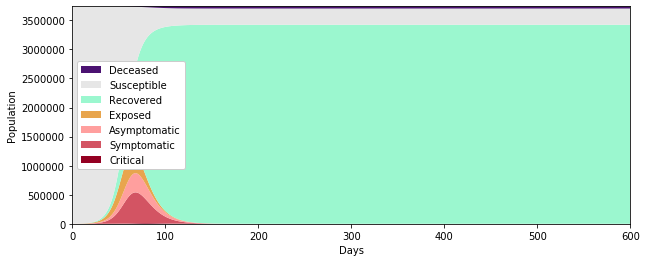

In [9]:
plot_stacked_graph(t, S, E, I_A, I_S, C, R, D)

Final totals:

In [10]:
Infected = E+I_A+I_S+C+D+R
Active_Infections = E+I_A+I_S+C
print('S = ',S[T-1])
print('E = ',S[T-1])
print('susceptible at end =', S[T-1])
print('total deceased = ', round(D[T-1]), ' (', round(D[T-1]*100/Infected[T-1],2), '% of infected)')
print('peak critical = ', round(max(C)))
print('peak infected = ', round(max(Active_Infections)))
print('time at peak = ', np.argmax(Active_Infections))
print('total infected = ', round(Infected[T-1]), ' (',round(Infected[T-1]*100/N_total,2), '% of population)')

S =  279293.6767557099
E =  279293.6767557099
susceptible at end = 279293.6767557099
total deceased =  37179.0  ( 1.07 % of infected)
peak critical =  11700.0
peak infected =  1240287.0
time at peak =  64
total infected =  3460737.0  ( 92.53 % of population)
